In [1]:
from ecnet.datasets import load_ysi, load_cn

smiles_ysi, ysi = load_ysi()
smiles_cn, cn = load_cn()

data_ysi = []
data_cn = []
smiles = []

for idx_ysi, smi_ysi in enumerate(smiles_ysi):
    for idx, smi in enumerate(smiles_cn):
        if smi_ysi == smi:
            data_ysi.append(ysi[idx_ysi])
            data_cn.append(cn[idx])
            smiles.append(smi_ysi)
            break

print(len(data_ysi), len(data_cn), len(smiles))

132 132 132


In [2]:
from sklearn.preprocessing import StandardScaler

scaler_ysi = StandardScaler()
scaler_cn = StandardScaler()
scaler_ysi.fit(data_ysi)
scaler_cn.fit(data_cn)
data_ysi = scaler_ysi.transform(data_ysi)
data_cn = scaler_cn.transform(data_cn)

print(min(data_ysi), max(data_ysi))
print(min(data_cn), max(data_cn))

[-0.74680261] [3.87871805]
[-1.38752046] [3.31798372]


In [3]:
from sklearn.model_selection import train_test_split

smiles_train, smiles_test, ysi_train, ysi_test, cn_train, cn_test = train_test_split(smiles, data_ysi, data_cn, test_size=0.25, random_state=0)

print(len(smiles_train), len(smiles_test))

99 33


In [4]:
################
### YSI ONLY ###
################

from ecnet.datasets import QSPRDataset

ds_train = QSPRDataset(smiles_train, ysi_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, ysi_test, backend='alvadesc')

In [5]:
from sklearn.decomposition import PCA
import torch

pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

print(ds_train.desc_vals.shape, ds_test.desc_vals.shape)

torch.Size([99, 99]) torch.Size([33, 99])


/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_52272/3723054795.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_52272/3723054795.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Epoch: 0 | Train loss: 1506.986581513376 | Valid loss: 9223372036854775807
Epoch: 25 | Train loss: 0.5095242664895274 | Valid loss: 0.2424735128879547
Epoch: 50 | Train loss: 0.045437196220243066 | Valid loss: 0.018323637545108795
Epoch: 75 | Train loss: 0.02383075392043049 | Valid loss: 0.015511736273765564
Epoch: 100 | Train loss: 0.16713494687538707 | Valid loss: 0.11963104456663132
Epoch: 125 | Train loss: 0.013909264665209886 | Valid loss: 0.008163334801793098
Epoch: 150 | Train loss: 0.014802108547001175 | Valid loss: 0.006211805623024702
Epoch: 175 | Train loss: 0.0415551585046518 | Valid loss: 0.036196283996105194
Epoch: 200 | Train loss: 0.003669634179183931 | Valid loss: 0.00380337773822248
Epoch: 225 | Train loss: 0.0035138413535826135 | Valid loss: 0.001871789456345141
Epoch: 250 | Train loss: 0.0033201708416031165 | Valid loss: 0.0018897508271038532
Epoch: 275 | Train loss: 0.006942276038788612 | Valid loss: 0.0033531992230564356
Epoch: 300 | Train loss: 0.0062605357644232

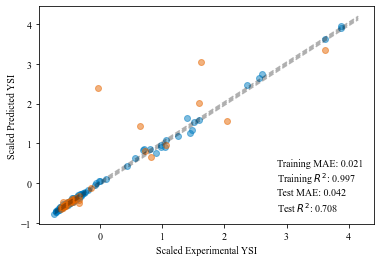

In [6]:
from ecnet import ECNet
from sklearn.metrics import median_absolute_error, r2_score
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText

model_ysi = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
model_ysi.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=25, lr=0.001)

pred_train = model_ysi(ds_train.desc_vals).detach().numpy()
pred_test = model_ysi(ds_test.desc_vals).detach().numpy()

mae_train = median_absolute_error(ysi_train, pred_train)
mae_test = median_absolute_error(ysi_test, pred_test)

r2_train = r2_score(ysi_train, pred_train)
r2_test = r2_score(ysi_test, pred_test)

min_val = min(min(pred_train), min(ysi_train)) - 0.05 * min(min(pred_train), min(ysi_train))
max_val = max(max(pred_train), max(ysi_train)) + 0.05 * max(max(pred_train), max(ysi_train))

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental YSI')
plt.ylabel('Scaled Predicted YSI')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + mae_test, max_val + mae_test], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - mae_test, max_val - mae_test], 'k--', alpha=0.3)
plt.scatter(ysi_train, pred_train, label='Training Set', color=(0, 114/235, 178/235), alpha=0.5)
plt.scatter(ysi_test, pred_test, label='Test Set', color=(213/235, 94/235, 0), alpha=0.5)
string = 'Training MAE: {:.3f}\nTraining $R^2$: {:.3f}\nTest MAE: {:.3f}\nTest $R^2$: {:.3f}'.format(
    mae_train, r2_train, mae_test, r2_test
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.0)
plt.gca().add_artist(text_box)
plt.show()


In [7]:
###############
### CN ONLY ###
###############

ds_train = QSPRDataset(smiles_train, cn_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, cn_test, backend='alvadesc')

In [8]:
pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

print(ds_train.desc_vals.shape, ds_test.desc_vals.shape)

torch.Size([99, 99]) torch.Size([33, 99])


/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_52272/2641696615.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_52272/2641696615.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Epoch: 0 | Train loss: 709.1256237608013 | Valid loss: 9223372036854775807
Epoch: 25 | Train loss: 0.30902630666440184 | Valid loss: 0.5736789703369141
Epoch: 50 | Train loss: 0.3533788975892645 | Valid loss: 0.35602691769599915
Epoch: 75 | Train loss: 0.10380177041797926 | Valid loss: 0.160490021109581
Epoch: 100 | Train loss: 0.23094439100135455 | Valid loss: 0.11430440843105316
Epoch: 125 | Train loss: 0.03707004033706405 | Valid loss: 0.03774839639663696
Epoch: 150 | Train loss: 0.05208117232629747 | Valid loss: 0.04897504299879074
Epoch: 175 | Train loss: 0.042324114901324116 | Valid loss: 0.056163132190704346
Epoch: 200 | Train loss: 0.08063398477988261 | Valid loss: 0.10601399838924408
Epoch: 225 | Train loss: 0.08915114189651584 | Valid loss: 0.05371484160423279
Epoch: 250 | Train loss: 0.02140760822503856 | Valid loss: 0.02443024516105652


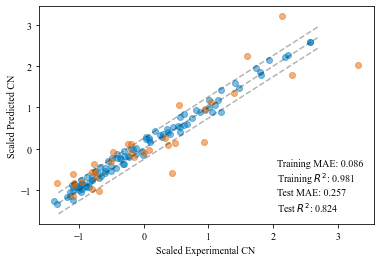

In [9]:
model_cn = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
model_cn.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=25, lr=0.001)

pred_train = model_cn(ds_train.desc_vals).detach().numpy()
pred_test = model_cn(ds_test.desc_vals).detach().numpy()

mae_train = median_absolute_error(cn_train, pred_train)
mae_test = median_absolute_error(cn_test, pred_test)

r2_train = r2_score(cn_train, pred_train)
r2_test = r2_score(cn_test, pred_test)

min_val = min(min(pred_train), min(cn_train)) - 0.05 * min(min(pred_train), min(cn_train))
max_val = max(max(pred_train), max(cn_train)) + 0.05 * max(max(pred_train), max(cn_train))

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental CN')
plt.ylabel('Scaled Predicted CN')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + mae_test, max_val + mae_test], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - mae_test, max_val - mae_test], 'k--', alpha=0.3)
plt.scatter(cn_train, pred_train, label='Training Set', color=(0, 114/235, 178/235), alpha=0.5)
plt.scatter(cn_test, pred_test, label='Test Set', color=(213/235, 94/235, 0), alpha=0.5)
string = 'Training MAE: {:.3f}\nTraining $R^2$: {:.3f}\nTest MAE: {:.3f}\nTest $R^2$: {:.3f}'.format(
    mae_train, r2_train, mae_test, r2_test
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.0)
plt.gca().add_artist(text_box)
plt.show()

In [10]:
##################
### YSI and CN ###
##################

import numpy as np

targets_train = np.concatenate((np.array(ysi_train), np.array(cn_train)), axis=1)
targets_test = np.concatenate((np.array(ysi_test), np.array(cn_test)), axis=1)

ds_train = QSPRDataset(smiles_train, targets_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, targets_test, backend='alvadesc')

print(ds_train.desc_vals.shape, ds_test.desc_vals.shape)
print(ds_train.target_vals.shape, ds_test.target_vals.shape)

torch.Size([99, 5305]) torch.Size([33, 5305])
torch.Size([99, 2]) torch.Size([33, 2])


In [11]:
pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

print(ds_train.desc_vals.shape, ds_test.desc_vals.shape)

torch.Size([99, 99]) torch.Size([33, 99])


/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_52272/2641696615.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_52272/2641696615.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Epoch: 0 | Train loss: 2121.6553617535214 | Valid loss: 9223372036854775807
Epoch: 25 | Train loss: 0.7897654605860059 | Valid loss: 1.3132814168930054
Epoch: 50 | Train loss: 0.2135818230383324 | Valid loss: 0.3149559795856476
Epoch: 75 | Train loss: 71.3913287935835 | Valid loss: 139.57318115234375
Epoch: 100 | Train loss: 0.10559662002505678 | Valid loss: 0.1418691724538803
Epoch: 125 | Train loss: 0.15661376477642494 | Valid loss: 0.1645989716053009
Epoch: 150 | Train loss: 0.035117012759049736 | Valid loss: 0.06102500483393669
Epoch: 175 | Train loss: 0.0268455096379374 | Valid loss: 0.03186164051294327
Epoch: 200 | Train loss: 0.02979172808541493 | Valid loss: 0.027324549853801727
Epoch: 225 | Train loss: 0.5601217348241445 | Valid loss: 0.5468035340309143
Epoch: 250 | Train loss: 0.03352720637551763 | Valid loss: 0.05264158174395561
Epoch: 275 | Train loss: 0.029492095366797665 | Valid loss: 0.03703315183520317
Epoch: 300 | Train loss: 0.019872397043262467 | Valid loss: 0.034448

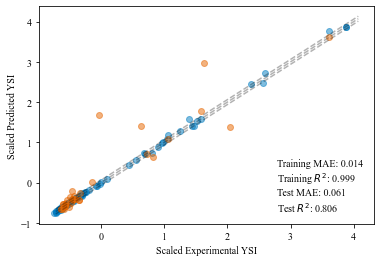

/Users/tjkessler/anaconda3/envs/ecnet/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


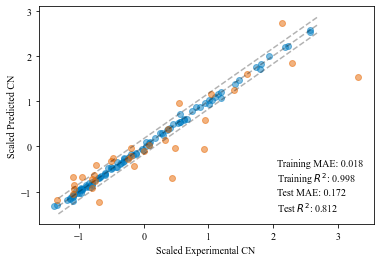

In [12]:
model_multi = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
model_multi.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=25, lr=0.001)

pred_train = model_multi(ds_train.desc_vals).detach().numpy()
pred_test = model_multi(ds_test.desc_vals).detach().numpy()

pred_train_ysi = [p[0] for p in pred_train]
pred_train_cn = [p[1] for p in pred_train]
pred_test_ysi = [p[0] for p in pred_test]
pred_test_cn = [p[1] for p in pred_test]

mae_train_ysi = median_absolute_error(ysi_train, pred_train_ysi)
mae_train_cn = median_absolute_error(cn_train, pred_train_cn)
mae_test_ysi = median_absolute_error(ysi_test, pred_test_ysi)
mae_test_cn = median_absolute_error(cn_test, pred_test_cn)

r2_train_ysi = r2_score(ysi_train, pred_train_ysi)
r2_train_cn = r2_score(cn_train, pred_train_cn)
r2_test_ysi = r2_score(ysi_test, pred_test_ysi)
r2_test_cn = r2_score(cn_test, pred_test_cn)

min_val = min(min(pred_train_ysi), min(ysi_train)) - 0.05 * min(min(pred_train_ysi), min(ysi_train))
max_val = max(max(pred_train_ysi), max(ysi_train)) + 0.05 * max(max(pred_train_ysi), max(ysi_train))

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental YSI')
plt.ylabel('Scaled Predicted YSI')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + mae_test_ysi, max_val + mae_test_ysi], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - mae_test_ysi, max_val - mae_test_ysi], 'k--', alpha=0.3)
plt.scatter(ysi_train, pred_train_ysi, label='Training Set', color=(0, 114/235, 178/235), alpha=0.5)
plt.scatter(ysi_test, pred_test_ysi, label='Test Set', color=(213/235, 94/235, 0), alpha=0.5)
string = 'Training MAE: {:.3f}\nTraining $R^2$: {:.3f}\nTest MAE: {:.3f}\nTest $R^2$: {:.3f}'.format(
    mae_train_ysi, r2_train_ysi, mae_test_ysi, r2_test_ysi
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.0)
plt.gca().add_artist(text_box)
plt.show()

min_val = min(min(pred_train_cn), min(cn_train)) - 0.05 * min(min(pred_train_cn), min(cn_train))
max_val = max(max(pred_train_cn), max(cn_train)) + 0.05 * max(max(pred_train_cn), max(cn_train))

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental CN')
plt.ylabel('Scaled Predicted CN')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + mae_test_cn, max_val + mae_test_cn], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - mae_test_cn, max_val - mae_test_cn], 'k--', alpha=0.3)
plt.scatter(cn_train, pred_train_cn, label='Training Set', color=(0, 114/235, 178/235), alpha=0.5)
plt.scatter(cn_test, pred_test_cn, label='Test Set', color=(213/235, 94/235, 0), alpha=0.5)
string = 'Training MAE: {:.3f}\nTraining $R^2$: {:.3f}\nTest MAE: {:.3f}\nTest $R^2$: {:.3f}'.format(
    mae_train_cn, r2_train_cn, mae_test_cn, r2_test_cn
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.0)
plt.gca().add_artist(text_box)
plt.show()

In [13]:
###########################
### 25 trials, JUST YSI ###
###########################

ds_train = QSPRDataset(smiles_train, ysi_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, ysi_test, backend='alvadesc')

pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

maes_train = []
maes_test = []
r2s_train = []
r2s_test = []

for _ in range(25):

    model_ysi = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
    model_ysi.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=0, lr=0.001)

    pred_train = model_ysi(ds_train.desc_vals).detach().numpy()
    pred_test = model_ysi(ds_test.desc_vals).detach().numpy()

    maes_train.append(median_absolute_error(ysi_train, pred_train))
    maes_test.append(median_absolute_error(ysi_test, pred_test))

    r2s_train.append(r2_score(ysi_train, pred_train))
    r2s_test.append(r2_score(ysi_test, pred_test))

print('Training set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_train), np.std(maes_train)))
print('Training set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_train), np.std(r2s_train)))
print('Test set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_test), np.std(maes_test)))
print('Test set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_test), np.std(r2s_test)))

/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_52272/2801915058.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_52272/2801915058.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Training set MAE: 0.049 +/- 0.040
Training set R2: 0.943 +/- 0.092
Test set MAE: 0.083 +/- 0.037
Test set R2: 0.763 +/- 0.291


In [14]:
##########################
### 25 trials, JUST CN ###
##########################

ds_train = QSPRDataset(smiles_train, cn_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, cn_test, backend='alvadesc')

pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

maes_train = []
maes_test = []
r2s_train = []
r2s_test = []

for _ in range(25):

    model_lhv = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
    model_lhv.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=0, lr=0.001)

    pred_train = model_lhv(ds_train.desc_vals).detach().numpy()
    pred_test = model_lhv(ds_test.desc_vals).detach().numpy()

    maes_train.append(median_absolute_error(cn_train, pred_train))
    maes_test.append(median_absolute_error(cn_test, pred_test))

    r2s_train.append(r2_score(cn_train, pred_train))
    r2s_test.append(r2_score(cn_test, pred_test))

print('Training set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_train), np.std(maes_train)))
print('Training set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_train), np.std(r2s_train)))
print('Test set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_test), np.std(maes_test)))
print('Test set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_test), np.std(r2s_test)))

/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_52272/3129248416.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_52272/3129248416.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Training set MAE: 0.084 +/- 0.056
Training set R2: 0.967 +/- 0.043
Test set MAE: 0.229 +/- 0.033
Test set R2: 0.794 +/- 0.081


In [15]:
#############################
### 25 trials, YSI and CN ###
#############################

targets_train = np.concatenate((np.array(ysi_train), np.array(cn_train)), axis=1)
targets_test = np.concatenate((np.array(ysi_test), np.array(cn_test)), axis=1)

ds_train = QSPRDataset(smiles_train, targets_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, ysi_test, backend='alvadesc')

pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

maes_train_ysi = []
maes_train_cn = []
maes_test_ysi = []
maes_test_cn = []
r2s_train_ysi = []
r2s_train_cn = []
r2s_test_ysi = []
r2s_test_cn = []

for _ in range(25):

    model_multi = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
    model_multi.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=0, lr=0.001)

    pred_train = model_multi(ds_train.desc_vals).detach().numpy()
    pred_test = model_multi(ds_test.desc_vals).detach().numpy()
    pred_train_ysi = [p[0] for p in pred_train]
    pred_train_cn = [p[1] for p in pred_train]
    pred_test_ysi = [p[0] for p in pred_test]
    pred_test_cn = [p[1] for p in pred_test]

    maes_train_ysi.append(median_absolute_error(ysi_train, pred_train_ysi))
    maes_train_cn.append(median_absolute_error(cn_train, pred_train_cn))
    maes_test_ysi.append(median_absolute_error(ysi_test, pred_test_ysi))
    maes_test_cn.append(median_absolute_error(cn_test, pred_test_cn))

    r2s_train_ysi.append(r2_score(ysi_train, pred_train_ysi))
    r2s_train_cn.append(r2_score(cn_train, pred_train_cn))
    r2s_test_ysi.append(r2_score(ysi_test, pred_test_ysi))
    r2s_test_cn.append(r2_score(cn_test, pred_test_cn))

print('YSI:')
print('Training set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_train_ysi), np.std(maes_train_ysi)))
print('Training set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_train_ysi), np.std(r2s_train_ysi)))
print('Test set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_test_ysi), np.std(maes_test_ysi)))
print('Test set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_test_ysi), np.std(r2s_test_ysi)))
print('\nCN:')
print('Training set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_train_cn), np.std(maes_train_cn)))
print('Training set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_train_cn), np.std(r2s_train_cn)))
print('Test set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_test_cn), np.std(maes_test_cn)))
print('Test set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_test_cn), np.std(r2s_test_cn)))

/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_52272/1772582639.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_52272/1772582639.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


YSI:
Training set MAE: 0.054 +/- 0.050
Training set R2: 0.957 +/- 0.073
Test set MAE: 0.090 +/- 0.052
Test set R2: 0.732 +/- 0.321

LHV:
Training set MAE: 0.078 +/- 0.050
Training set R2: 0.921 +/- 0.120
Test set MAE: 0.233 +/- 0.057
Test set R2: 0.708 +/- 0.202
